In [1]:
import mlrose_hiive as mlrh
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [7, 7]

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay

random_state = 2020

In [2]:
X_cred, y_cred = fetch_openml("credit-g", return_X_y=True)

# y_cred[0], cred_mapping = pd.factorize(y_cred[0])
le = LabelEncoder()
y_cred = le.fit_transform(y_cred)

# switch labels around
# good risk: 0
# bad risk: 1
y_cred[y_cred==1] = 3  # Temp
y_cred[y_cred==0] = 1
y_cred[y_cred==3] = 0

# Create holdout test set
X_cred_train, X_cred_test, y_cred_train, y_cred_test = train_test_split(X_cred, y_cred, test_size=0.2,
                                                                        random_state=random_state,
                                                                        stratify=y_cred)
def get_data(data):
    return data["X"], data["y"], data["name"]

# Standardize
scaler_cred = StandardScaler()
scaler_cred.fit(X_cred_train)
X_cred_train = scaler_cred.transform(X_cred_train)
X_cred_test = scaler_cred.transform(X_cred_test)

# Create data sets
cred = {"X": X_cred_train, "y": y_cred_train, "name": "Credit Train"}
cred_test = {"X": X_cred_test, "y": y_cred_test, "name": "Credit Test"}

In [3]:
def print_metric(clf, data_set, fit=False):
    X, y, _ = get_data(data_set)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=random_state)
    
    if not fit:
        clf.fit(X_train, y_train)
        
    y_pred = clf.predict(X_test)

    name = "Credit CV"
    print("{} -          Accuracy: ".format(name), round(accuracy_score(y_test, y_pred), 4))
    print("{} - Balanced Accuracy: ".format(name), round(balanced_accuracy_score(y_test, y_pred), 4))
    print("{} -     AVG Precision: ".format(name), round(average_precision_score(y_test, clf.predicted_probs), 4))

In [4]:
def plot_fitness_iteration(curve, title, max_fitness=None, x="Iteration", y="Fitness"):
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title)
    length = len(curve)
    plt.plot(range(length), curve, label=y, lw=2)

    if max_fitness:
        plt.plot(range(length), [max_fitness] * length, label="Max Fitness", lw=1, color="darkorange")
    
    plt.legend(loc="best")
    plt.show()

In [5]:
def build_confusion_matrix(clf, data_set, clf_name):
    X, y, name = get_data(data_set)
    y_pred = nn_model.predict(X)
    cm = confusion_matrix(y, y_pred)
    print("Confusion Matrix raw: ")
    print(cm)
    cm = confusion_matrix(y, y_pred, normalize="true")
    display_labels = ["good risk", "bad risk"]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix - {}".format(clf_name))
    plt.show()

In [6]:
def full_training_run(clf, data_set, clf_name):
    X, y, name = get_data(data_set)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=random_state)
    
    fit_clf = clf.fit(X_train, y_train)
    
    plot_fitness_iteration(fit_clf.fitness_curve, "{} Fitness Curve".format(clf_name))
    print_metric(fit_clf, data_set, fit=True)

    precision, recall, _ = precision_recall_curve(y_test, clf.predicted_probs)
    avg_precision = average_precision_score(y_test, clf.predicted_probs)

    _, ax = plt.subplots()
    title = 'Precision-Recall Curve - {}'.format(name)
    ax.set_title(title)
    disp = PrecisionRecallDisplay(precision, recall, avg_precision, clf_name)
    disp.plot(ax=ax)
    
    build_confusion_matrix(fit_clf, data_set, clf_name)
    return fit_clf

In [7]:
def build_learning_curve(clf, data_set, clf_name, scoring="accuracy", axes=None, ylim=None, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    print(clf)
    X, y, name = get_data(data_set)
    title = "{} : {}".format(clf_name, name)
    
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(30, 10))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel(scoring)

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        clf, X, y, cv=cv, n_jobs=n_jobs, scoring=scoring, train_sizes=train_sizes, return_times=True, random_state=random_state
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel(scoring)
    axes[2].set_title("Performance of the model")
    plt.show()

In [8]:
def final_test_metrics(clf, data_set, clf_name):
    X_test, y_test, name = get_data(data_set)
    
    y_pred = clf.predict(X_test)

    name = "Credit CV"
    print("{} -          Accuracy: ".format(name), round(accuracy_score(y_test, y_pred), 4))
    print("{} - Balanced Accuracy: ".format(name), round(balanced_accuracy_score(y_test, y_pred), 4))
    print("{} -     AVG Precision: ".format(name), round(average_precision_score(y_test, clf.predicted_probs), 4))
    
    precision, recall, _ = precision_recall_curve(y_test, clf.predicted_probs)
    avg_precision = average_precision_score(y_test, clf.predicted_probs)

    _, ax = plt.subplots()
    title = 'Precision-Recall Curve - {}'.format(name)
    ax.set_title(title)
    disp = PrecisionRecallDisplay(precision, recall, avg_precision, clf_name)
    disp.plot(ax=ax)
    
    build_confusion_matrix(clf, data_set, clf_name)

# Gradient Descent

## Gradient Descent Training

In [21]:
# Tune max_iters and learning_rate_init
grid_search = {
    "max_iters": [5000, 10000, 25000, 50000],
    "learning_rate_init": [0.001, 0.1, 0.1, 0.5, 1],
    "hidden_layers_sizes": [[6, 6]],
    "activation": [mlrh.neural.activation.relu],
    "is_classifier": [True],
}
X, y, _ = get_data(cred)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=random_state)

runner = mlrh.NNGSRunner(x_train=X_train, y_train=y_train,
                           x_test=X_test, y_test=y_test,
                           experiment_name="full_grid_search",
                           output_directory="nn_gradient_descent/",
                           algorithm=mlrh.algorithms.gradient_descent,
                           grid_search_parameters=grid_search,
                           iteration_list = [1000, 2500, 5000, 10000],
                           hidden_layer_sizes=[[6,6]],
                           bias=True,
                           early_stopping=True,
                           clip_max=1,
                           max_attempts=1000,
                           generate_curves=True,
                           seed=random_state,
                           n_jobs=-1
                          )
run_stats, curves, cv_results, best_est = runner.run()

Running nngs_gd
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.3min finished


*****************
*** Run START ***
*****************
max_iters:[25000], hidden_layers_sizes:[[6, 6]], is_classifier:[True], init_state:[[ 0.97255366  0.74678389  0.01949105 -0.45632857 -0.32616254 -0.56609147
 -0.44704571 -0.31336881  0.72431787 -0.68660066 -0.71822551  0.51416056
  0.47264984 -0.28867382 -0.31781397  0.3336061  -0.56579872  0.12285396
 -0.75164244 -0.36052703  0.90642775 -0.72528642  0.13882619  0.95133097
  0.00673412  0.33532841 -0.931617   -0.08776127 -0.68829727 -0.04790207
 -0.66059512  0.79251667 -0.25321248 -0.24061414  0.71663318  0.29212211
  0.1669234   0.33670005 -0.64441476  0.69849603 -0.11525484  0.66293542
  0.52784143  0.83938195 -0.85885315 -0.68766917  0.27378846  0.11139137
 -0.61614257 -0.14868803  0.02684042 -0.46124483  0.19804004 -0.55965211
 -0.39827501 -0.90321103  0.12864012  0.87206441  0.60605528  0.3946103
 -0.07723145  0.32486922  0.49933128  0.06290978 -0.03437975 -0.94145153
  0.78856621  0.66306417  0.47568692  0.7969946  -0.53853172 

max_iters:[25000], hidden_layers_sizes:[[6, 6]], is_classifier:[True], init_state:[[ 0.97255366  0.74678389  0.01949105 -0.45632857 -0.32616254 -0.56609147
 -0.44704571 -0.31336881  0.72431787 -0.68660066 -0.71822551  0.51416056
  0.47264984 -0.28867382 -0.31781397  0.3336061  -0.56579872  0.12285396
 -0.75164244 -0.36052703  0.90642775 -0.72528642  0.13882619  0.95133097
  0.00673412  0.33532841 -0.931617   -0.08776127 -0.68829727 -0.04790207
 -0.66059512  0.79251667 -0.25321248 -0.24061414  0.71663318  0.29212211
  0.1669234   0.33670005 -0.64441476  0.69849603 -0.11525484  0.66293542
  0.52784143  0.83938195 -0.85885315 -0.68766917  0.27378846  0.11139137
 -0.61614257 -0.14868803  0.02684042 -0.46124483  0.19804004 -0.55965211
 -0.39827501 -0.90321103  0.12864012  0.87206441  0.60605528  0.3946103
 -0.07723145  0.32486922  0.49933128  0.06290978 -0.03437975 -0.94145153
  0.78856621  0.66306417  0.47568692  0.7969946  -0.53853172 -0.64007898
  0.22831624 -0.96666104 -0.40135551  0.33

In [22]:
best_est.best_params_

{'activation': <function mlrose_hiive.neural.activation.relu.relu(x, deriv=False)>,
 'hidden_layer_sizes': [6, 6],
 'hidden_layers_sizes': [6, 6],
 'is_classifier': True,
 'learning_rate_init': 0.001,
 'max_iters': 25000}

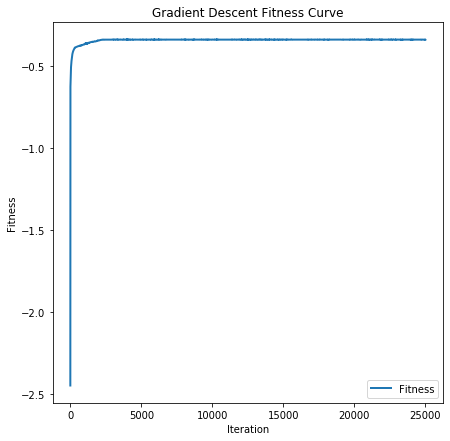

Credit CV -          Accuracy:  0.7438
Credit CV - Balanced Accuracy:  0.6728
Credit CV -     AVG Precision:  0.5367
Confusion Matrix raw: 
[[519  41]
 [ 95 145]]


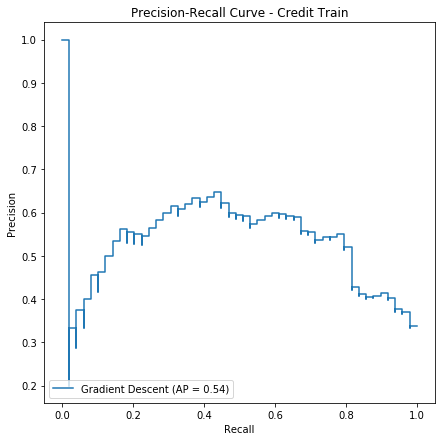

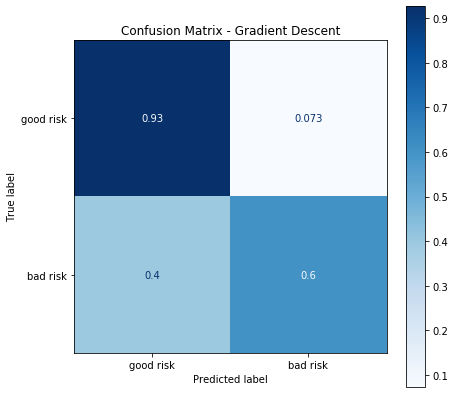

NeuralNetwork(activation='relu', algorithm='gradient_descent', bias=True,
              clip_max=1.0, curve=True, early_stopping=True,
              hidden_nodes=[6, 6], is_classifier=True, learning_rate=0.001,
              max_attempts=200, max_iters=25000, mutation_prob=0.1,
              pop_size=200, random_state=2020, restarts=0,
              schedule=GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001))


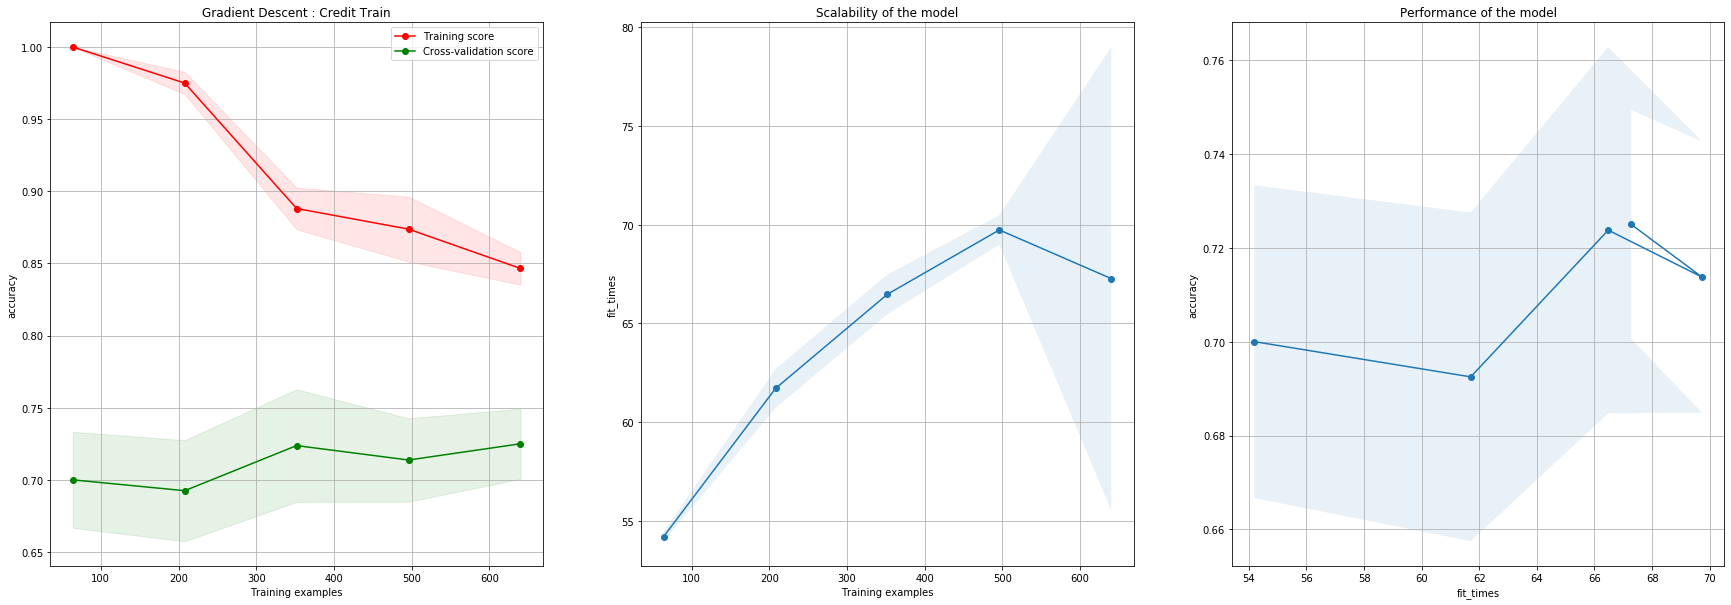

In [23]:
nn_model = mlrh.NeuralNetwork(hidden_nodes = [6, 6],
                                activation = 'relu',
                                algorithm = 'gradient_descent',
                                max_iters = 25000,
                                bias = True,
                                is_classifier = True,
                                learning_rate = 0.001,
                                early_stopping = True,
                                clip_max = 1.0,
                                max_attempts =200,
                                curve=True,
                                random_state = random_state)

full_training_run(nn_model, cred, "Gradient Descent")
build_learning_curve(nn_model, cred, "Gradient Descent", scoring="accuracy")

## Gradient Descent Final Fit

In [24]:
nn_model = mlrh.NeuralNetwork(hidden_nodes = [6, 6],
                                activation = 'relu',
                                algorithm = 'gradient_descent',
                                max_iters = 10000,
                                bias = True,
                                is_classifier = True,
                                learning_rate = 0.001,
                                early_stopping = True,
                                clip_max = 1.0,
                                max_attempts =200,
                                curve=True,
                                random_state = random_state)

X_train, y_train, name = get_data(cred)

fit_clf = nn_model.fit(X_train, y_train)

## Gradient Descent Final Test Metrics

Credit CV -          Accuracy:  0.73
Credit CV - Balanced Accuracy:  0.6357
Credit CV -     AVG Precision:  0.5535
Confusion Matrix raw: 
[[122  18]
 [ 36  24]]


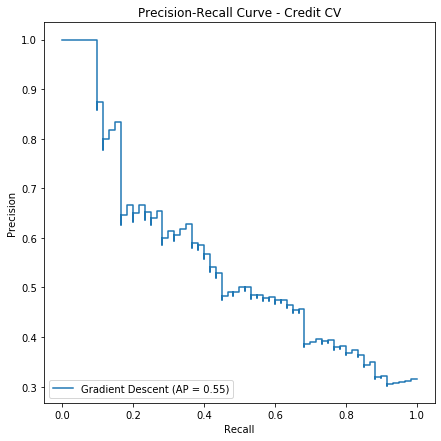

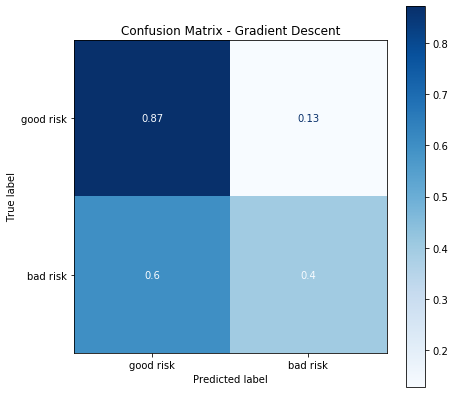

In [25]:
final_test_metrics(fit_clf, cred_test, "Gradient Descent")

# Simulated Annealing

## Simulated Annealing Training

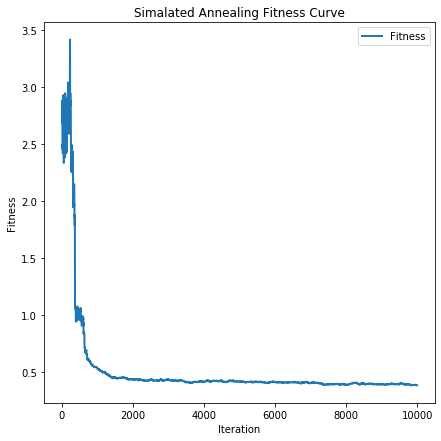

Credit CV -          Accuracy:  0.7188
Credit CV - Balanced Accuracy:  0.6434
Credit CV -     AVG Precision:  0.6116
Confusion Matrix raw: 
[[493  67]
 [109 131]]


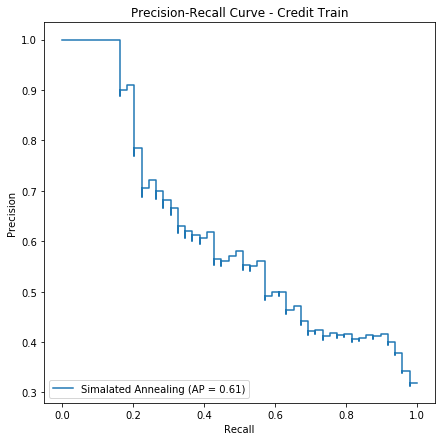

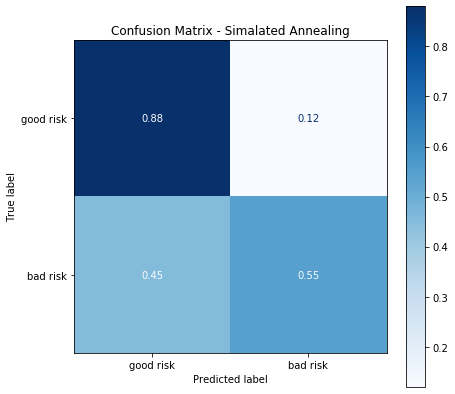

NeuralNetwork(activation='relu', algorithm='simulated_annealing', bias=True,
              clip_max=1.0, curve=True, early_stopping=True,
              hidden_nodes=[6, 6], is_classifier=True, learning_rate=0.5,
              max_attempts=1000, max_iters=10000, mutation_prob=0.1,
              pop_size=200, random_state=2020, restarts=0,
              schedule=GeomDecay(init_temp=5, decay=0.99, min_temp=0.001))


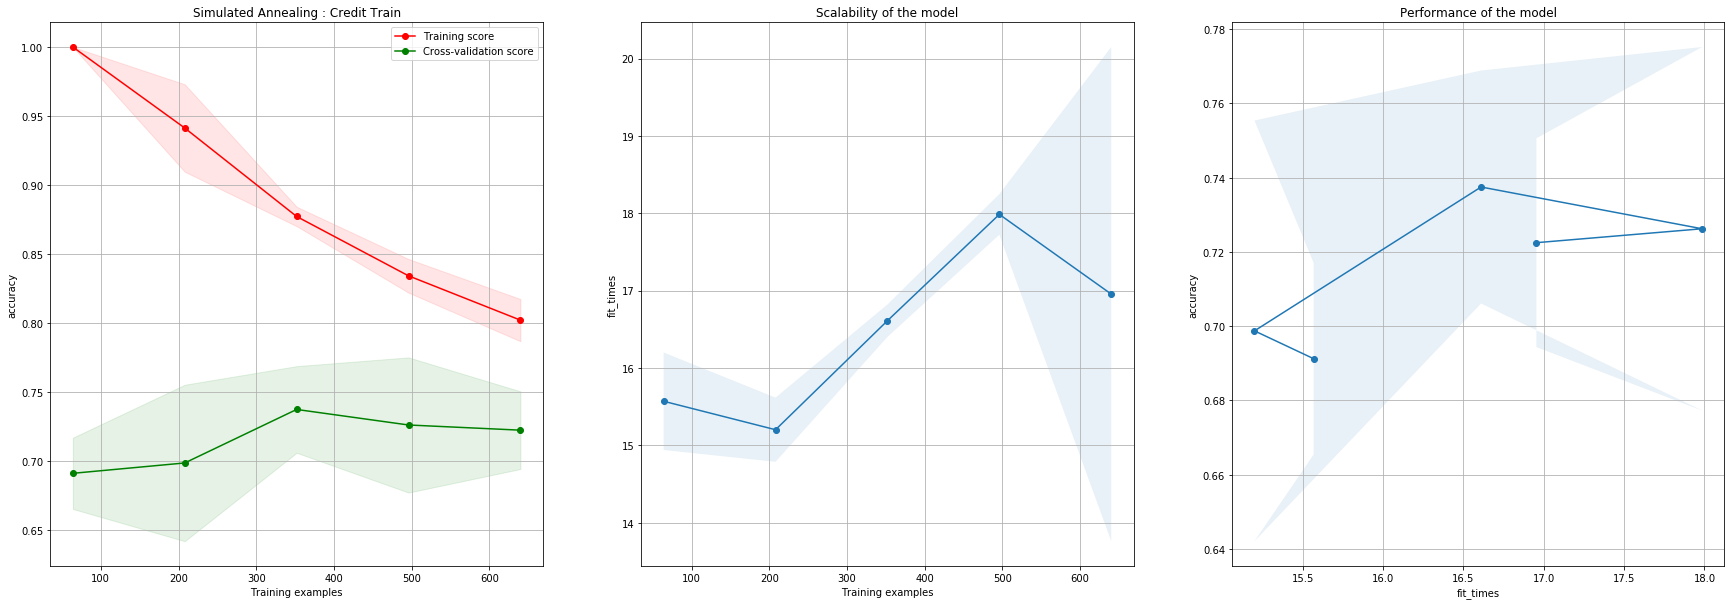

In [12]:
nn_model = mlrh.NeuralNetwork(hidden_nodes=[6, 6],
                                activation='relu',
                                algorithm='simulated_annealing',
                                schedule=mlrh.GeomDecay(5),
                                max_iters=10000,
                                max_attempts=1000,
                                bias=True,
                                is_classifier=True,
                                learning_rate=0.5,
                                early_stopping=True,
                                clip_max=1.0,
                                curve=True,
                                random_state=random_state)

full_training_run(nn_model, cred, "Simalated Annealing")
build_learning_curve(nn_model, cred, "Simulated Annealing", scoring="accuracy")

## Simulated Annealing Descent Final Fit

In [13]:
nn_model = mlrh.NeuralNetwork(hidden_nodes=[6, 6],
                                activation='relu',
                                algorithm='simulated_annealing',
                                schedule=mlrh.GeomDecay(5),
                                max_iters=10000,
                                max_attempts=1000,
                                bias=True,
                                is_classifier=True,
                                learning_rate=0.5,
                                early_stopping=True,
                                clip_max=1.0,
                                curve=True,
                                random_state=random_state)

X_train, y_train, name = get_data(cred)

fit_clf = nn_model.fit(X_train, y_train)

## Simulated Annealing Final Test Metrics

Credit CV -          Accuracy:  0.735
Credit CV - Balanced Accuracy:  0.6726
Credit CV -     AVG Precision:  0.5639
Confusion Matrix raw: 
[[116  24]
 [ 29  31]]


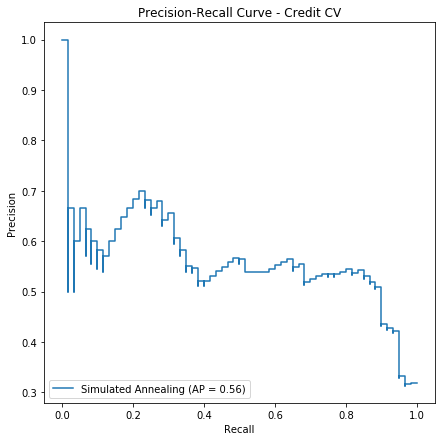

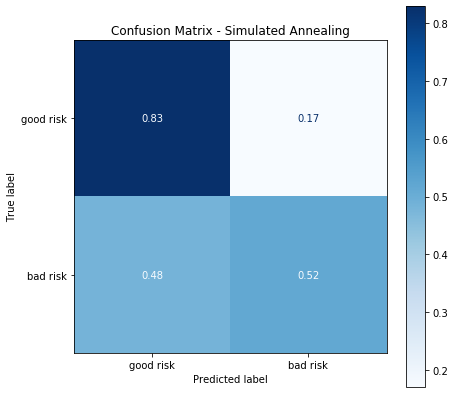

In [14]:
final_test_metrics(fit_clf, cred_test, "Simulated Annealing")

# Random Hill Climbing

## Random Hill Climbing Training

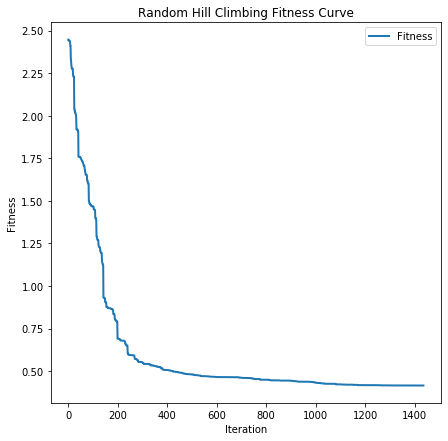

Credit CV -          Accuracy:  0.7438
Credit CV - Balanced Accuracy:  0.6671
Credit CV -     AVG Precision:  0.5705
Confusion Matrix raw: 
[[510  50]
 [105 135]]


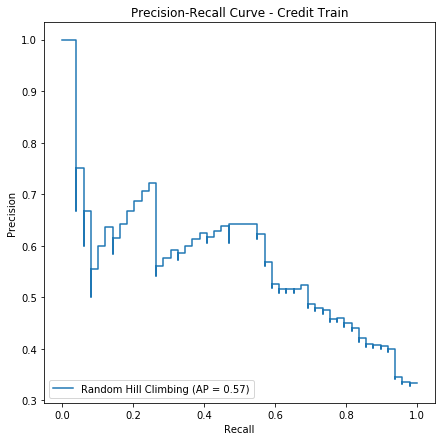

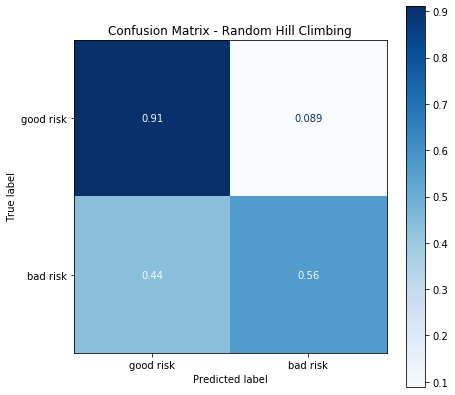

NeuralNetwork(activation='relu', algorithm='random_hill_climb', bias=True,
              clip_max=1.0, curve=True, early_stopping=True,
              hidden_nodes=[6, 6], is_classifier=True, learning_rate=0.5,
              max_attempts=100, max_iters=5000, mutation_prob=0.1, pop_size=200,
              random_state=2020, restarts=20,
              schedule=GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001))


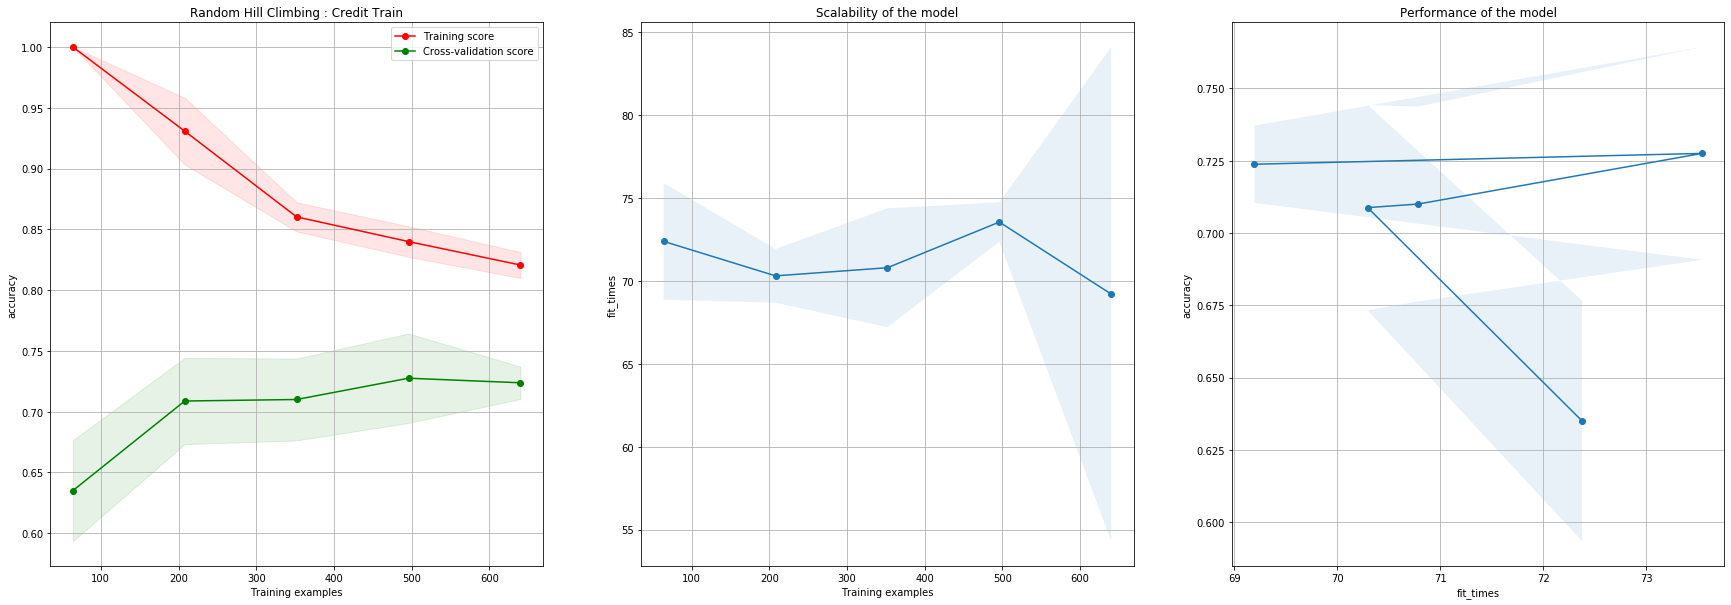

In [15]:
nn_model = mlrh.NeuralNetwork(hidden_nodes=[6, 6],
                                activation='relu',
                                algorithm='random_hill_climb',
                                max_iters=5000,
                                max_attempts=100,
                                bias=True,
                                restarts=20,
                                is_classifier=True,
                                learning_rate=0.5,
                                early_stopping=True,
                                clip_max=1.0,
                                curve=True,
                                random_state=random_state)

full_training_run(nn_model, cred, "Random Hill Climbing")
build_learning_curve(nn_model, cred, "Random Hill Climbing", scoring="accuracy")

## Random Hill Climbing Descent Final Fit

In [16]:
nn_model = mlrh.NeuralNetwork(hidden_nodes=[6, 6],
                                activation='relu',
                                algorithm='random_hill_climb',
                                max_iters=5000,
                                max_attempts=100,
                                bias=True,
                                restarts=20,
                                is_classifier=True,
                                learning_rate=0.5,
                                early_stopping=True,
                                clip_max=1.0,
                                curve=True,
                                random_state=random_state)

X_train, y_train, name = get_data(cred)

fit_clf = nn_model.fit(X_train, y_train)

## Random Hill Climbing Final Test Metrics

Credit CV -          Accuracy:  0.735
Credit CV - Balanced Accuracy:  0.625
Credit CV -     AVG Precision:  0.5797
Confusion Matrix raw: 
[[126  14]
 [ 39  21]]


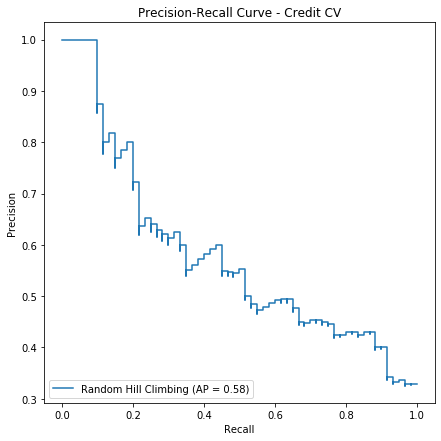

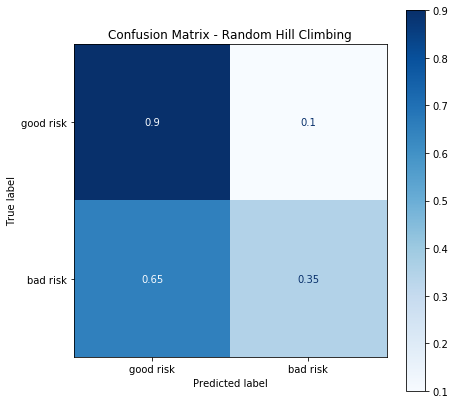

In [17]:
final_test_metrics(fit_clf, cred_test, "Random Hill Climbing")

# Genetic Algorithm

## Genetic Algorithm Training

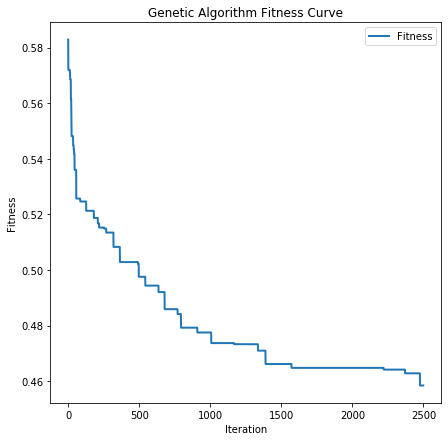

Credit CV -          Accuracy:  0.7
Credit CV - Balanced Accuracy:  0.59
Credit CV -     AVG Precision:  0.5414
Confusion Matrix raw: 
[[515  45]
 [142  98]]


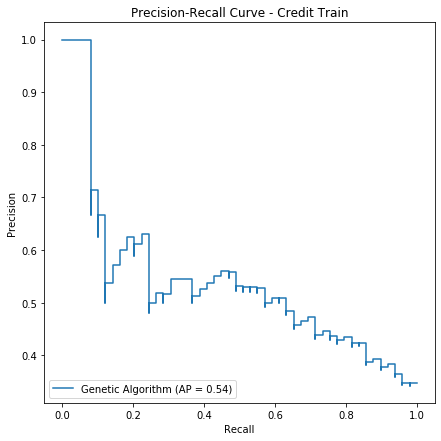

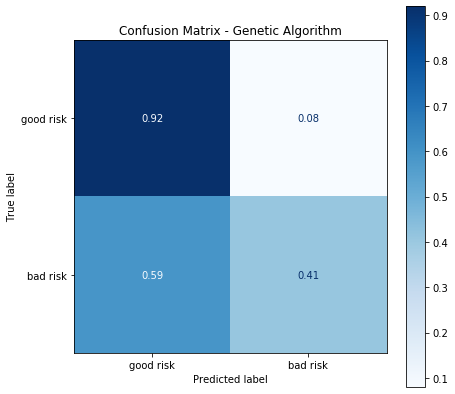

NeuralNetwork(activation='relu', algorithm='genetic_alg', bias=True,
              clip_max=1.0, curve=True, early_stopping=True,
              hidden_nodes=[6, 6], is_classifier=True, learning_rate=0.001,
              max_attempts=1000, max_iters=2500, mutation_prob=0.1,
              pop_size=1000, random_state=2020, restarts=0,
              schedule=GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001))


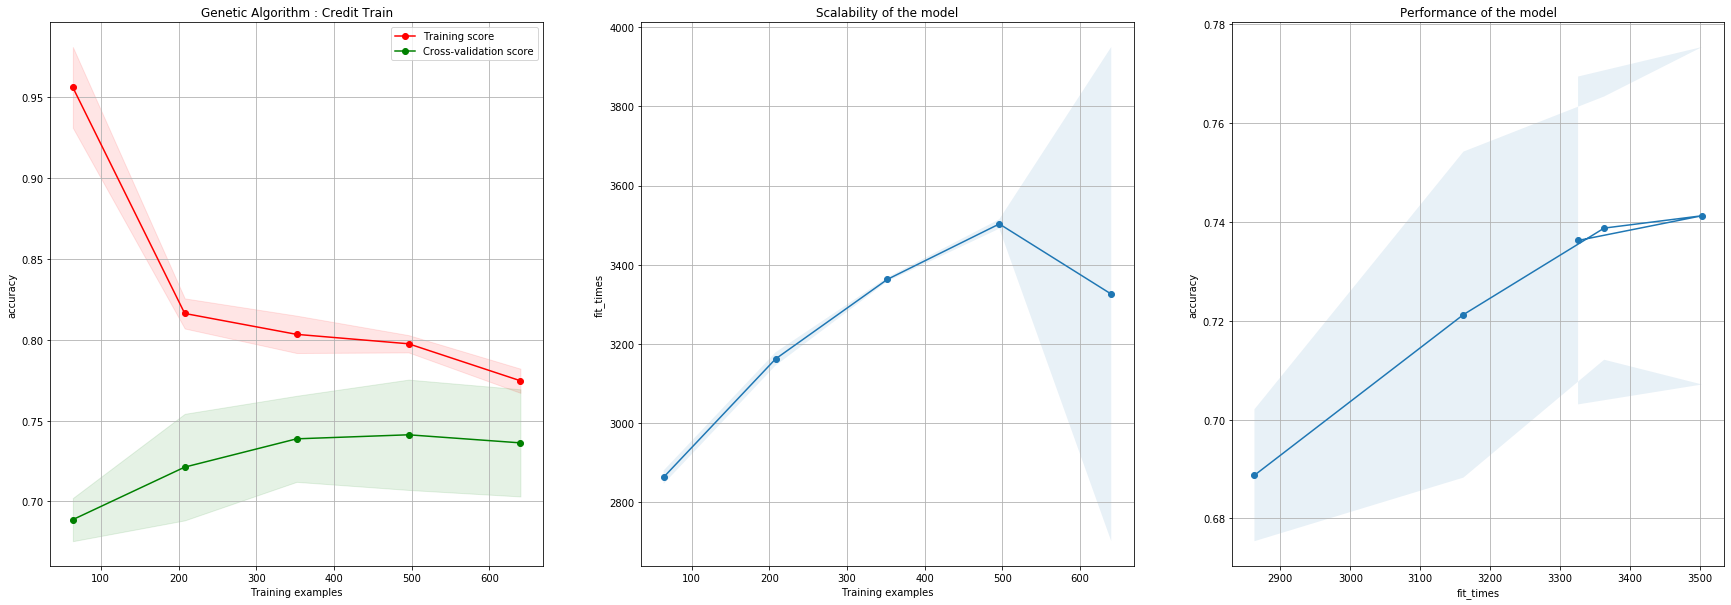

In [18]:
nn_model = mlrh.NeuralNetwork(hidden_nodes=[6, 6],
                              activation='relu',
                              algorithm='genetic_alg',
                              max_iters=2500,
                              max_attempts=1000,
                              bias=True,
                              is_classifier=True,
                              learning_rate=0.001,
                              mutation_prob=0.1,
                              pop_size=1000,
                              early_stopping=True,
                              clip_max=1.0,
                              curve=True,
                              random_state=random_state)

full_training_run(nn_model, cred, "Genetic Algorithm")
build_learning_curve(nn_model, cred, "Genetic Algorithm", scoring="accuracy")

## Genetic Algorithm Descent Final Fit

In [19]:
nn_model = mlrh.NeuralNetwork(hidden_nodes=[6, 6],
                              activation='relu',
                              algorithm='genetic_alg',
                              max_iters=2500,
                              max_attempts=1000,
                              bias=True,
                              is_classifier=True,
                              learning_rate=0.001,
                              mutation_prob=0.1,
                              pop_size=1000,
                              early_stopping=True,
                              clip_max=1.0,
                              curve=True,
                              random_state=random_state)

X_train, y_train, name = get_data(cred)

fit_clf = nn_model.fit(X_train, y_train)

## Genetic Algorithm Final Test Metrics

Credit CV -          Accuracy:  0.715
Credit CV - Balanced Accuracy:  0.606
Credit CV -     AVG Precision:  0.5219
Confusion Matrix raw: 
[[123  17]
 [ 40  20]]


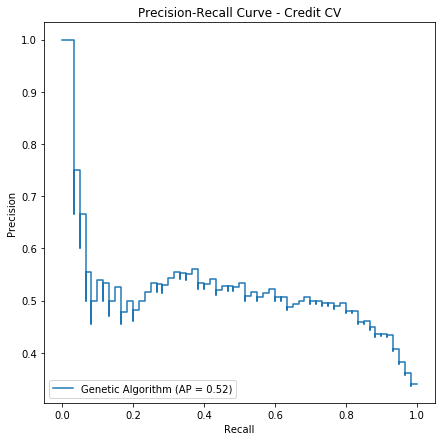

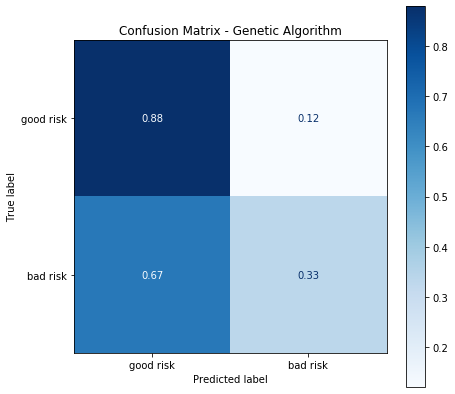

In [20]:
final_test_metrics(fit_clf, cred_test, "Genetic Algorithm")